In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [2]:
parent_directory = os.path.abspath(os.path.join('..'))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, '..'))

sys.path.append(parent_directory)
sys.path.append(grandparent_directory)

print("Current sys.path:", sys.path)  # To confirm that the path is correctly added
print("Parent directory:", os.path.abspath(os.path.join('...')))  # To verify the direct

from data_processing_utils.data_processing_functions import load_list_from_txt
train_feather_path = "../../data/train_test_splits/cog_train_family_tax_level.feather"
test_feather_path = "../../data/train_test_splits/cog_test_family_tax_level.feather"
global_vocab_path = "../../data/train_test_splits/global_vocab.txt"

train_df = pd.read_feather(train_feather_path)
val_df = pd.read_feather(test_feather_path)
global_vocab = load_list_from_txt(global_vocab_path)

train_values = train_df.iloc[:, 1:-13].values

sample_names = train_df.iloc[:, 0].values
cog_names = train_df.iloc[:, 1:-13].columns.tolist()
print(f"Number of samples = {len(sample_names)}")
print(f"Number of COGs = {len(cog_names)}")
print(f"Vocabulary size = {len(global_vocab)}")


Current sys.path: ['c:\\Users\\kolda\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'c:\\Users\\kolda\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'c:\\Users\\kolda\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'c:\\Users\\kolda\\AppData\\Local\\Programs\\Python\\Python312', '', 'c:\\Users\\kolda\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages', 'c:\\Users\\kolda\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\win32', 'c:\\Users\\kolda\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\kolda\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\kolda\\OneDrive\\Documents\\gene-context\\mlm\\set_transformer', 'c:\\Users\\kolda\\OneDrive\\Documents\\gene-context\\mlm']
Parent directory: c:\Users\kolda\OneDrive\Documents\gene-context\mlm\set_transformer\post_training\
Number of samples = 90445
Number of COGs = 12873
Vocabulary size = 12873


In [ ]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=50, learning_rate=100, max_iter=5000)
train_samples = tsne_bin.fit_transform(train_values)

In [53]:
taxa_level = "class"  #'domain', 'phylum', 'class', 'order', 'family', 'group', 'species'
taxa_labels = train_df[taxa_level]
print(f"Found {len(np.unique(taxa_labels))} unique groups at {taxa_level} level for {len(taxa_labels)} samples")

Found 546 unique groups at class level for 90445 samples


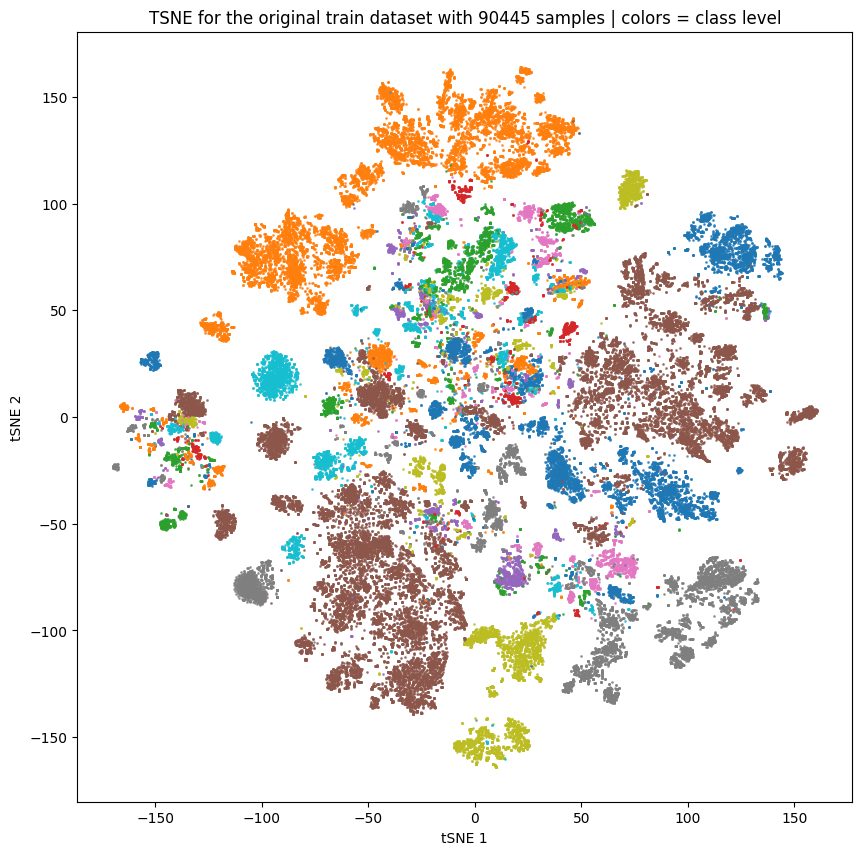

In [55]:
import seaborn as sns
unique_labels = np.unique(taxa_labels)
#palette = sns.color_palette("husl", len(unique_labels))  # "husl" can handle many categories
palette = sns.color_palette("tab10", len(unique_labels))  # Get distinct colors
color_map = {label: color for label, color in zip(unique_labels, palette)}

plt.figure(figsize=(10, 10))
for label in unique_labels:
    mask = taxa_labels == label  # Filter points for the specific label
    plt.scatter(train_samples[:, 0][mask], train_samples[:, 1][mask], color=color_map[label], label=label, s=1, alpha=0.7)

#plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"TSNE for the original train dataset with {len(sample_names)} samples | colors = {taxa_level} level")
plt.show()

Load the pre-trained model

In [3]:
from set_transformer.utils.architecture import GenomeSetTransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(os.getcwd())

# Load pretrained SetTransformer
set_transformer = GenomeSetTransformer(vocab_size=len(global_vocab), d_model=124,
                                            num_heads=4, num_sab=2, dropout=0.1)

# Load SetTransformer weights using map_location=device
set_transformer_state = torch.load('full_set_transf_embedd_124_heads_4_sab_2_BCE.pth ', map_location=device,weights_only=True)   #COG_high3_256_4_8_BCE_40.pth
# Remove the "module." prefix if trained with DataParallel
from collections import OrderedDict
new_state_dict = OrderedDict()
for key, value in set_transformer_state.items():
    new_key = key.replace("module.", "")  # Remove "module." prefix
    new_state_dict[new_key] = value

# Load into model
set_transformer.load_state_dict(new_state_dict)


vocab_size = set_transformer.vocab_size  # This should be defined in your model (e.g., the original number of COGs)
set_transformer_embeddings = set_transformer.cog_embedding.weight[:vocab_size].detach().cpu().numpy()
print(f"SetTransformer embeddings shape: {set_transformer_embeddings.shape}")

c:\Users\kolda\OneDrive\Documents\gene-context\mlm\set_transformer\post_training
SetTransformer embeddings shape: (12873, 124)


## Feature space

#### 1. Download a table of COG annotations

In [92]:
import requests

# URL for the COG definitions file
url = "https://ftp.ncbi.nih.gov/pub/COG/COG2020/data/cog-20.def.tab"
response = requests.get(url)
if response.status_code == 200:
    with open("cog-20.def.tab", "wb") as f:
        f.write(response.content)
    print("Downloaded cog-20.def.tab successfully.")
else:
    raise Exception(f"Error downloading file: HTTP {response.status_code}")

Downloaded cog-20.def.tab successfully.


In [98]:
# Read the tab-delimited file (it has no header)
df_cog = pd.read_csv("cog-20.def.tab", sep="\t", header=None, engine="python", encoding="latin1")
# Assign column names; based on the provided sample:
df_cog = pd.read_csv("cog-20.def.tab", sep="\t", header=None, engine="python", encoding="latin1")
df_cog.columns = ["COG_ID", "Category", "Description", "Gene_Symbol", "Function", "Extra", "PDB_ID"]
# ---------------------------
# 2. Map to Canonical Metacategories
# ---------------------------
# Define canonical mapping for each letter.
meta_map = {
    "S": "Poorly Characterized", "R": "Poorly Characterized",
    "Q": "Metabolism", "P": "Metabolism", "I": "Metabolism",
    "H": "Metabolism", "F": "Metabolism", "E": "Metabolism",
    "G": "Metabolism", "C": "Metabolism",
    "O": "Cellular Processes & Signaling", "U": "Cellular Processes & Signaling", "W": "Cellular Processes & Signaling",
    "N": "Cellular Processes & Signaling", "M": "Cellular Processes & Signaling", "T": "Cellular Processes & Signaling",
    "V": "Cellular Processes & Signaling", "D": "Cellular Processes & Signaling",
    "B": "Information Storage & Processing", "L": "Information Storage & Processing", "K": "Information Storage & Processing",
    "A": "Information Storage & Processing", "J": "Information Storage & Processing"
}

def assign_metacategory(cat_str, meta_map):
    """
    For a given category string (which may contain multiple letters),
    assign a canonical metacategory using majority rule.
    """
    counts = {}
    for letter in str(cat_str):
        if letter in meta_map:
            mc = meta_map[letter]
            counts[mc] = counts.get(mc, 0) + 1
    if counts:
        return max(counts, key=counts.get)
    else:
        return None

# Process all rows: keep original Category and compute Meta_Category.
functional_df = df_cog[["COG_ID", "Category"]].copy()
functional_df["Meta_Category"] = functional_df["Category"].apply(lambda x: assign_metacategory(x, meta_map))
functional_df = functional_df.dropna(subset=["Meta_Category"])
functional_df = functional_df.sort_values("COG_ID").reset_index(drop=True)
functional_df["COG_Index"] = functional_df.index
print("First few rows of functional_df with Meta_Category:")
print(functional_df)

First few rows of functional_df with Meta_Category:
       COG_ID Category                   Meta_Category  COG_Index
0     COG0001        H                      Metabolism          0
1     COG0002        E                      Metabolism          1
2     COG0003        P                      Metabolism          2
3     COG0004        P                      Metabolism          3
4     COG0005        F                      Metabolism          4
...       ...      ...                             ...        ...
4750  COG5946        V  Cellular Processes & Signaling       4750
4751  COG5947        V  Cellular Processes & Signaling       4751
4752  COG5948        V  Cellular Processes & Signaling       4752
4753  COG5949        V  Cellular Processes & Signaling       4753
4754  COG5950        V  Cellular Processes & Signaling       4754

[4755 rows x 4 columns]


#### 3. Visualize the original COG space with annotated categories

In [ ]:
df_cogs = pd.DataFrame(train_values.T)

# Add the list of strings as the first column
df_cogs.insert(0, 'COG_ID', cog_names)
df_cogs = df_cogs.merge(functional_df[["COG_ID", "Category", "Meta_Category"]], on="COG_ID", how="left") 
df_cogs #no archae

,COG_ID,0,1,2,3,4,5,6,7,8,...,90437,90438,90439,90440,90441,90442,90443,90444,Category,Meta_Category
0,COG0001,0,0,0,3,1,0,3,3,3,...,1,3,3,0,0,0,0,1,H,Metabolism
1,COG0002,0,0,1,0,1,0,1,1,1,...,0,1,1,1,1,1,1,1,E,Metabolism
2,COG0003,1,0,0,0,0,1,0,1,3,...,0,0,0,0,0,0,0,0,P,Metabolism
3,COG0004,0,2,2,0,0,0,3,0,1,...,0,0,2,2,1,2,2,1,P,Metabolism
4,COG0005,1,0,0,0,0,1,0,1,0,...,0,1,0,1,1,1,1,2,F,Metabolism
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12868,arCOG15264,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
12869,arCOG15268,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
12870,arCOG15271,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
12871,arCOG15273,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN


In [270]:
df_cogs['Meta_Category'].fillna('no_label', inplace=True)
df_cogs = df_cogs.dropna(subset=["Meta_Category"])
df_cogs_val = df_cogs.iloc[:, 1:-2].values
pd.DataFrame(df_cogs_val)

C:\Users\kolda\AppData\Local\Temp\ipykernel_9576\3449966199.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cogs['Meta_Category'].fillna('no_label', inplace=True)


,0,1,2,3,4,5,6,7,8,9,...,90435,90436,90437,90438,90439,90440,90441,90442,90443,90444
0,0,0,0,3,1,0,3,3,3,1,...,0,4,1,3,3,0,0,0,0,1
1,0,0,1,0,1,0,1,1,1,1,...,0,0,0,1,1,1,1,1,1,1
2,1,0,0,0,0,1,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,2,0,0,0,3,0,1,0,...,0,1,0,0,2,2,1,2,2,1
4,1,0,0,0,0,1,0,1,0,3,...,2,1,0,1,0,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [279]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=10, learning_rate=5, max_iter=2000)
train_features_tsne = tsne_bin.fit_transform(df_cogs_val)

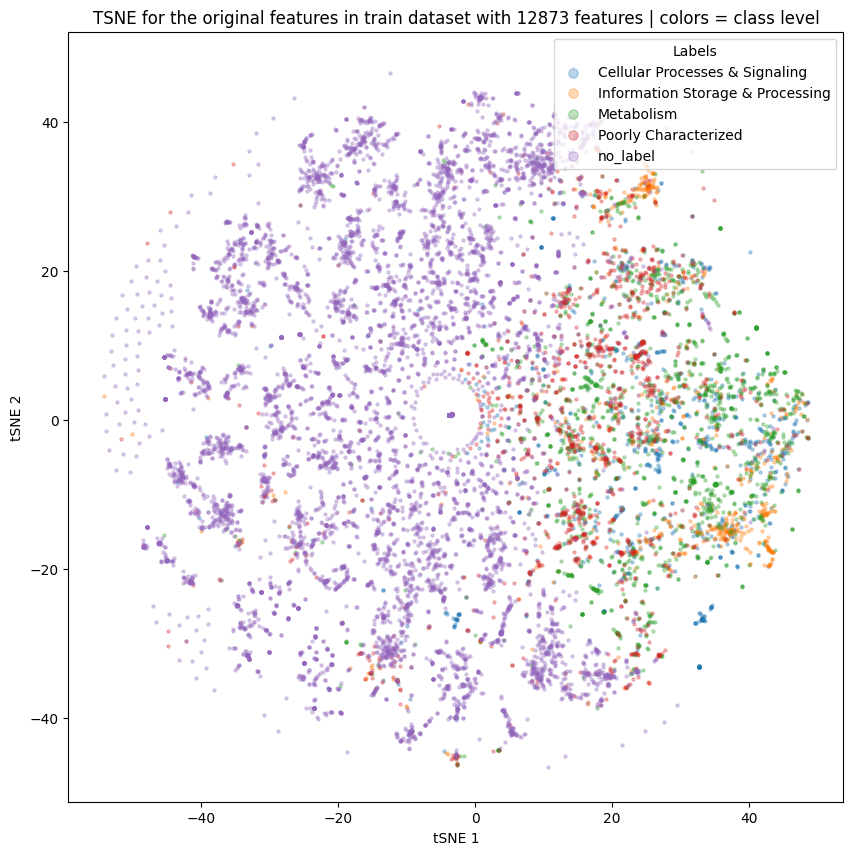

In [ ]:
category_names = df_cogs["Meta_Category"]
unique_labels = np.unique(category_names)
#palette = sns.color_palette("husl", len(unique_labels))  # "husl" can handle many categories
palette = sns.color_palette("tab10", len(unique_labels))  
color_map = {label: color for label, color in zip(unique_labels, palette)}

plt.figure(figsize=(10, 10))
for label in unique_labels:
    mask = category_names == label  # Filter points for the specific label
    plt.scatter(train_features_tsne[:, 0][mask], train_features_tsne[:, 1][mask], color=color_map[label], label=label, s=5, alpha=0.3)

plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"TSNE for the original features in train dataset with {len(train_features_tsne)} features | colors = functions")
plt.show()

#### 6. Visualize the set of learned embedding weights with annotations

In [ ]:
# Assuming your set_transformer is already loaded and has an attribute "cog_embedding"
vocab_size = set_transformer.vocab_size  # This is the number of COG tokens (without the pad token)
# Extract only the COG identity embeddings (ignoring any additional count processing)
cog_identity_embeddings = set_transformer.cog_embedding.weight[:vocab_size].detach().cpu().numpy()
print("COG identity embeddings shape:", cog_identity_embeddings.shape)

df_cog_embedd = pd.DataFrame(cog_identity_embeddings)
df_cog_embedd["COG_Index"] = np.arange(vocab_size)
df_cog_embedd = df_cog_embedd.merge(functional_df[["COG_Index", "Category", "Meta_Category"]], on="COG_Index", how="left")
df_cog_embedd['Meta_Category'].fillna('no_label', inplace=True)
df_cog_embedd = df_cog_embedd.dropna(subset=["Meta_Category"])

df_cog_embedd_val = df_cog_embedd.iloc[:, :-3].values
print("COG identity embeddings shape:", df_cog_embedd_val.shape)
pd.DataFrame(df_cog_embedd_val)

COG identity embeddings shape: (12873, 124)


C:\Users\kolda\AppData\Local\Temp\ipykernel_9576\1576995148.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cog_embedd['Meta_Category'].fillna('no_label', inplace=True)


,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,-0.746309,-0.711446,-1.240367,0.740698,-0.495946,0.608609,1.133903,0.189368,0.941538,-0.401329,...,1.121309,0.827062,-0.830704,0.434813,-0.688233,0.558366,-1.022453,-0.251981,-0.600927,-0.093975
1,0.263890,-1.044412,-0.020146,-0.581752,-1.068766,-0.949092,-0.606044,-0.880140,-0.600673,-0.020265,...,-1.211721,0.924581,0.934454,0.342803,0.920683,0.534290,-0.243514,-0.731447,1.012455,-0.813089
2,-0.367998,-0.590882,-1.646822,-1.474349,0.398760,0.153204,-0.167811,-0.808345,0.796464,-4.655059,...,0.099389,-1.048968,0.410158,0.342658,1.057266,-0.729216,0.653384,-0.425116,-0.472855,-1.125140
3,0.319543,-0.570602,-0.524519,0.645294,-0.445652,-0.888659,0.718321,0.098360,-0.467017,0.722381,...,-1.140081,-0.146469,0.212781,0.496368,0.854276,-0.105287,0.779350,-0.365531,0.337149,-0.343254
4,0.186529,-1.471247,2.341617,-0.873101,1.144723,0.008136,0.290839,-1.159291,-0.964830,2.440984,...,-1.352183,-2.581659,-0.714364,0.378276,0.861723,0.028129,0.710606,-1.196905,-0.011757,0.051588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12868,0.144574,0.093519,0.012858,0.431954,0.192429,-0.096616,-0.218936,0.192892,0.056136,0.053705,...,-0.142295,-0.372730,-0.229705,0.315063,-0.227220,-0.401773,0.281519,-0.379734,-0.123149,-0.078991
12869,0.299078,0.317986,0.241159,0.224482,0.221790,-0.240076,-0.109879,0.283262,-0.315799,0.017461,...,-0.364707,0.037652,-0.514776,0.415892,0.310997,-0.107938,0.128209,-0.476677,-0.131471,0.204127
12870,-0.143828,0.094854,-0.061094,0.189306,0.054923,-0.023461,-0.011619,0.368020,0.057459,0.275236,...,0.191993,-0.035034,-0.319362,-0.073640,0.288948,-0.289222,0.331593,-0.024376,-0.280951,0.274204
12871,0.182838,0.306625,0.299847,0.349550,0.174884,-0.042162,-0.015834,-0.159090,-0.144131,-0.138264,...,-0.217831,-0.174237,-0.410241,-0.238709,0.082063,-0.197644,0.532690,-0.216069,-0.071671,-0.025808


In [264]:
tsne_bin = TSNE(n_components=2, random_state=4, perplexity=30, learning_rate=100, max_iter=3000)
embedd_weights_tsne = tsne_bin.fit_transform(df_cog_embedd_val)
embedd_weights_tsne.shape

(12873, 2)

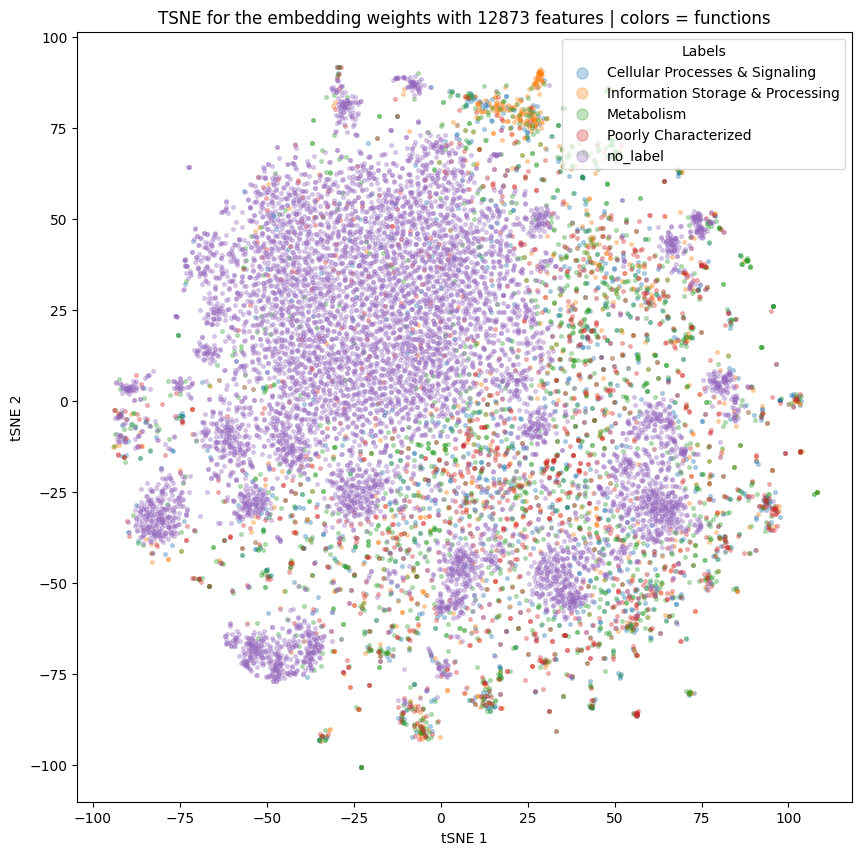

In [282]:
category_names = df_cog_embedd["Meta_Category"]
unique_labels = np.unique(category_names)
#palette = sns.color_palette("husl", len(unique_labels))  # "husl" can handle many categories
palette = sns.color_palette("tab10", len(unique_labels))  # Get distinct colors
color_map = {label: color for label, color in zip(unique_labels, palette)}

plt.figure(figsize=(10, 10))
for label in unique_labels:
    mask = category_names == label  # Filter points for the specific label
    plt.scatter(embedd_weights_tsne[:, 0][mask], embedd_weights_tsne[:, 1][mask], color=color_map[label], label=label, s=7, alpha=0.3)

plt.legend(title="Labels", markerscale=3, loc="upper right")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.title(f"TSNE for the embedding weights with {len(embedd_weights_tsne)} features | colors = functions")
plt.show()

In [ ]:
# Define a method to extract embeddings
def extract_embeddings(model, tokens, mask):
    # Forward pass to get embeddings and logits
    emb_cog = model.cog_embedding(tokens[:, :, 0].long())  # COG embeddings
    binary_counts = (tokens[:, :, 1].float() > 0).float().unsqueeze(-1)
    emb_count = model.count_linear(binary_counts)  # Count embeddings
    
    # Sum embeddings: COG + Count embeddings
    embeddings = emb_cog + emb_count  # Shape: (B, N, d_model)
    
    return embeddings

In [5]:
from torch.utils.data import  DataLoader
from data_processing_utils.data_processing_functions import GenomeDataset, collate_genomes
def generate_noisy_dataset(df, global_vocab, batch_size, pad_idx, fn_rate, fp_rate, count_noise_std=0, random_state=42):
     dataset = GenomeDataset(df, global_vocab,
                               false_negative_rate=fn_rate, false_positive_rate=fp_rate,
                               count_noise_std=count_noise_std, random_state=random_state)
     dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_genomes(batch, pad_idx=pad_idx))    
     return dataset_loader

In [307]:
train_df

,accession,COG0001,COG0002,COG0003,COG0004,COG0005,COG0006,COG0007,COG0008,COG0009,...,coding_bases,genome_size,gc_percentage,domain,phylum,class,order,family,group,species
0,GB_GCA_022360575.1,0,0,0,0,2,2,0,2,2,...,3129601,3600082,31.619502,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__UBA12077,g__UBA12077,s__UBA12077 sp022360575
1,GB_GCA_958296245.1,6,1,0,2,1,2,1,2,1,...,2366465,2685284,63.981165,d__Bacteria,p__Chloroflexota,c__Dehalococcoidia,o__SAR202,f__G958296245,g__G958296245,s__G958296245 sp958296245
2,GB_GCA_902783595.1,0,0,0,0,1,1,0,2,2,...,1646403,1774762,54.081674,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__P3,g__UBA1711,s__UBA1711 sp902783595
3,GB_GCA_017556795.1,0,0,0,0,0,0,0,1,0,...,623628,674245,46.274277,d__Bacteria,p__Patescibacteria,c__Saccharimonadia,o__Saccharimonadales,f__Nanosyncoccaceae,g__Nanosyncoccus,s__Nanosyncoccus sp017556795
4,GB_GCA_027007465.1,0,0,0,0,0,0,0,1,1,...,731366,847401,27.770072,d__Bacteria,p__Patescibacteria,c__ABY1,o__BM507,f__JALTFF01,g__JALTFF01,s__JALTFF01 sp027007465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22652,GB_GCA_900542525.1,0,1,0,1,1,1,0,2,0,...,1493987,1668041,52.941864,d__Bacteria,p__Actinomycetota,c__Coriobacteriia,o__Coriobacteriales,f__Eggerthellaceae,g__Anaerotardibacter,s__Anaerotardibacter sp900542525
22653,GB_GCA_902805975.1,0,1,2,1,1,3,0,4,1,...,3073626,3528030,67.549917,d__Bacteria,p__Actinomycetota,c__Rubrobacteria,o__Rubrobacterales,f__Rubrobacteraceae,g__Rubrobacter_D,s__Rubrobacter_D sp902805975
22654,GB_GCA_023391835.1,0,1,0,2,1,2,0,1,1,...,2310314,2613651,59.884200,d__Bacteria,p__Bacillota_A,c__Clostridia,o__Oscillospirales,f__Ethanoligenenaceae,g__JAEWAE01,s__JAEWAE01 sp023391835
22655,GB_GCA_024762745.1,0,0,0,3,0,2,1,3,0,...,1468729,1565485,35.624679,d__Bacteria,p__Campylobacterota,c__Campylobacteria,o__Campylobacterales,f__Sulfurimonadaceae,g__Sulfurimonas,s__Sulfurimonas sp024762745


In [ ]:
import tqdm
# Define a hook to capture attention weights
def capture_attention_weights(module, input, output):
    # Save the attention weights (output is a tuple of attention output and attention weights)
    global attention_weights
    attention_weights = output[1]  # The second element is the attention weights

# Register hook to capture attention weights from each SAB block's MHA layer
def register_hooks(model):
    for sab_block in model.sab_blocks:
        # Register the hook to the MultiheadAttention layer in each SAB block
        sab_block.mha.register_forward_hook(capture_attention_weights)

train_feather_path ="../../data/train_test_splits/cog_train_family_tax_level.feather"
train_df = pd.read_feather(train_feather_path)
# Downsample to N rows
N = 1000  # Replace with the desired number of rows
train_df = train_df.sample(n=N, random_state=42) 
batch_size = 10
pad_idx = len(global_vocab) # padding size
train_loader = generate_noisy_dataset(train_df, global_vocab, batch_size, pad_idx, fn_rate=0, fp_rate=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Matrix 

attention_scores_mtr = torch.zeros(pad_idx, pad_idx, device=device)# np.zeros((pad_idx, pad_idx), dtype=object) # [[(0,0) for _ in range(pad_idx)] for _ in range(pad_idx)]
#print(tuple_list)

print(f"pad_idx = {pad_idx}")
set_transformer.to(device)
register_hooks(set_transformer)

#train_bar = tqdm(train_loader, desc="Epoch {} Training".format(epoch+1))
set_transformer.eval()
count = 0
with torch.no_grad():
    for tokens, mask, targets in train_loader:
        print(f"i = {count}")

        count += 1
        tokens = tokens.to(device)
        mask = mask.to(device)
        preds = set_transformer(tokens, mask)
        

        batch_size = tokens.shape[0]
        seq_len = tokens.shape[1]

        # Convert tokens to indices (COG IDs)
        cog_ids = tokens[:, :, 0].long()  # (batch_size, seq_len)
        token_counts = tokens[:, :, 1]    # (batch_size, seq_len)


        for sample_id in range(len(cog_ids)):
            present_tokens_mask = token_counts[sample_id] > 0
            present_cogs_ids = cog_ids[sample_id][present_tokens_mask]

         #   print(f"present_cogs_ids shape = {present_cogs_ids.shape}")
            
            #print(values)
            for i, row_cog_id in enumerate(present_cogs_ids):
               # print(f"i = {i}; row_cog_id = {row_cog_id}")
                values = attention_weights[sample_id][i][present_tokens_mask]

               # print(f"values shape = {values.shape}")
              #  attention_scores_mtr[row_cog_id, present_cogs_ids] += attention_values[i]
                #print(row_cog_id)
                attention_scores_mtr[row_cog_id, present_cogs_ids]  += values
                


        # sequence_lengths = (tokens[:, :, 0] != pad_idx).sum(dim=1)
        # preds = set_transformer(tokens, mask)
        # for sample_i in range(len(attention_weights)):
        #     for cog_attending_i in range(len(attention_weights[sample_i])): # row index
        #         cogs_attended = np.zeros(len(global_vocab))
        #     cog_1_att_ = []

        #     for cog_1 in range(len(attention_weights[sample_i])):
        #         for cog_2 in range(len(attention_weights[sample_i][cog_1])):
        #             if tokens[sample_i][cog_1][1] > 0 and tokens[sample_i][cog_2][1] > 0: #if both cogs were originally present in the sample (i.e. not padded)
        #                 cog_id_1 = int(tokens[sample_i][cog_1][0])
        #                 cog_id_2 = int(tokens[sample_i][cog_2][0])
        #                 attention_scores_mtr[cog_id_1][cog_id_2] += attention_weights[sample_i][cog_1][cog_2]

    #         print()
       # print(attention_weights[sample_i])





pad_idx = 12873
i = 0
tensor([    1,     4,     5,     7,     8,    11,    12,    14,    15,    16,
           17,    18,    19,    20,    22,    23,    26,    27,    28,    29,
           32,    33,    34,    35,    36,    37,    39,    40,    42,    44,
           46,    47,    48,    49,    50,    52,    53,    54,    55,    56,
           57,    58,    59,    60,    70,    71,    75,    76,    77,    78,
           79,    80,    82,    83,    84,    85,    86,    87,    88,    89,
           90,    91,    92,    94,    95,    96,    97,    98,    99,   100,
          101,   102,   103,   106,   108,   109,   110,   113,   114,   115,
          122,   124,   125,   126,   127,   128,   134,   135,   136,   140,
          142,   146,   147,   148,   149,   150,   151,   154,   155,   160,
          162,   163,   164,   165,   166,   167,   169,   170,   171,   175,
          176,   177,   178,   182,   183,   184,   185,   186,   187,   188,
          189,   190,   191,   192,   193,

KeyboardInterrupt: 

In [32]:
attention_scores_mtr
attention_weights[sample_id]

tensor([[4.8362e-05, 3.6686e-04, 5.4890e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.0427e-06, 1.3815e-04, 1.5814e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.3083e-06, 3.1127e-04, 1.3664e-05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [9.4965e-06, 4.1169e-06, 1.3789e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.4965e-06, 4.1169e-06, 1.3789e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.4965e-06, 4.1169e-06, 1.3789e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0')

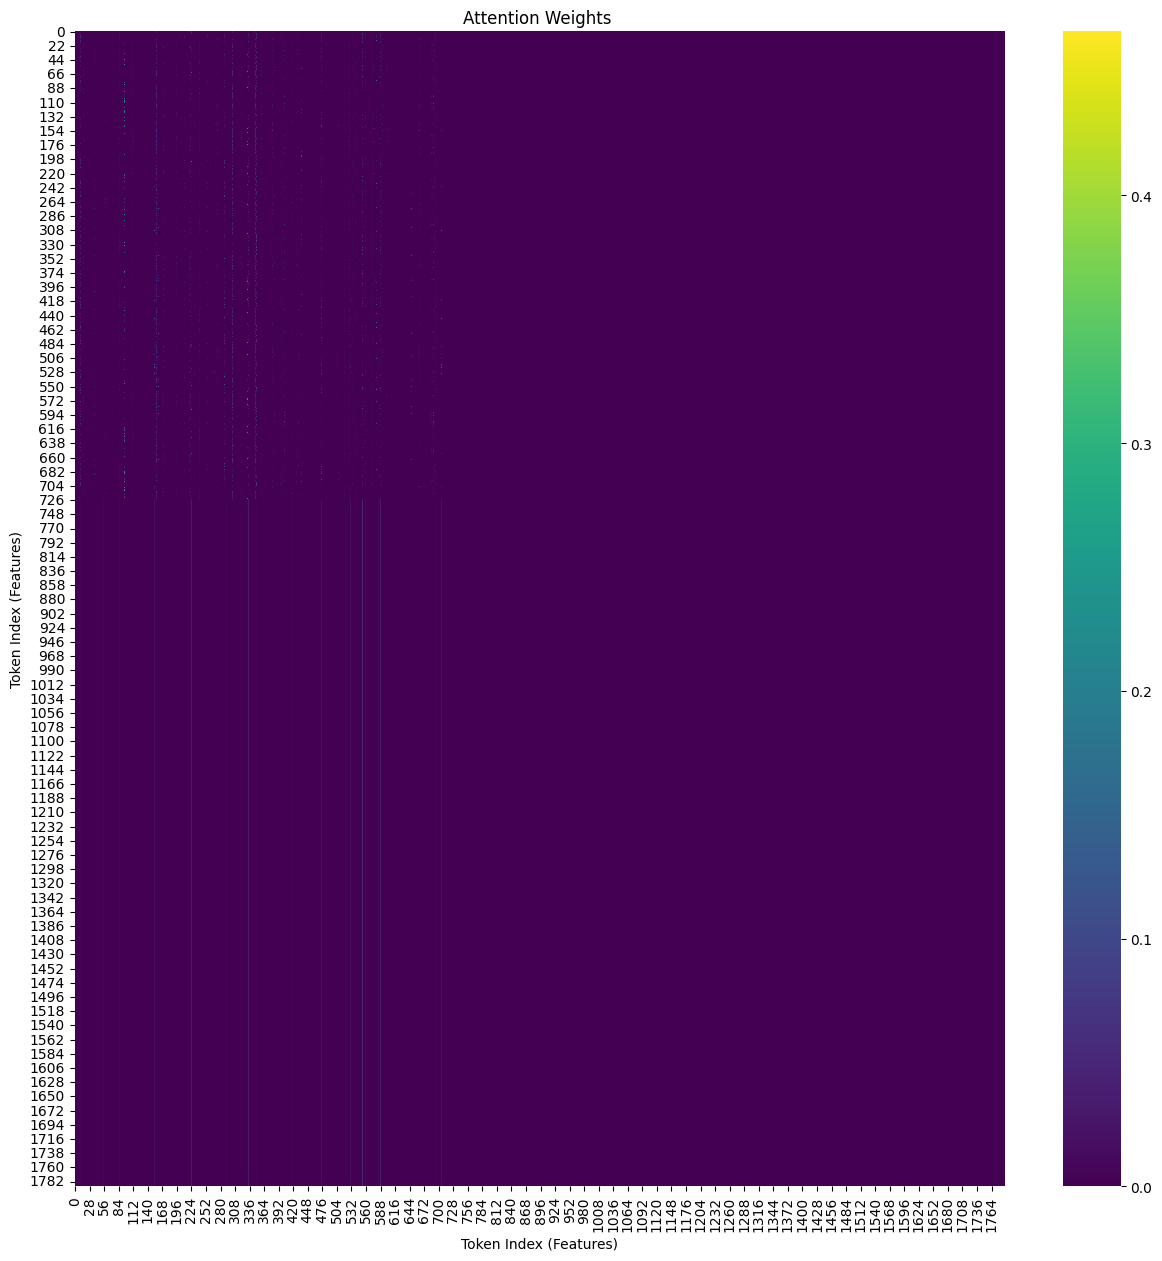

In [36]:
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(attention_weights[sample_id].cpu().numpy(), cmap='viridis', cbar=True)
plt.title(f"Attention Weights ")
plt.xlabel("Token Index (Features)")
plt.ylabel("Token Index (Features)")
plt.show()


In [342]:
import torch

set_transformer.eval()
attention_scores_mtr = torch.zeros(len(global_vocab), len(global_vocab))  # Assuming global_vocab holds all possible tokens

with torch.no_grad():
    for tokens, mask, targets in train_loader:
        preds = set_transformer(tokens, mask)  # Forward pass

        batch_size = tokens.shape[0]
        seq_len = tokens.shape[1]

        # Convert tokens to indices (COG IDs)
        cog_ids = tokens[:, :, 0].long()  # (batch_size, seq_len)
        token_counts = tokens[:, :, 1]    # (batch_size, seq_len)

        # Get boolean mask where token counts are > 0 (valid tokens)
        valid_mask = token_counts > 0  # (batch_size, seq_len)

        # Mask out padded positions in attention weights
        masked_attention_weights = attention_weights * valid_mask.unsqueeze(1) * valid_mask.unsqueeze(2)  # (batch_size, seq_len, seq_len)

        # Iterate over the batch efficiently
        for sample_i in range(batch_size):
            valid_cog_ids = cog_ids[sample_i][valid_mask[sample_i]]  # Get valid COG IDs for this sample
            attn_matrix = masked_attention_weights[sample_i][:valid_cog_ids.shape[0], :valid_cog_ids.shape[0]]  # Trim to valid tokens

            # Use advanced indexing to update the attention matrix efficiently
            idx1, idx2 = valid_cog_ids.unsqueeze(1), valid_cog_ids.unsqueeze(0)  # Convert to broadcastable shapes
            attention_scores_mtr.index_add_(0, idx1.flatten(), attn_matrix.flatten())  # Add to attention matrix


RuntimeError: index_add_(): Number of indices (1737) should be equal to source.size(dim): (3017169), for dim: 0